In [123]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import nibabel as nib
from tqdm import tqdm
from pathlib import Path
import sys
import os
import shutil
import time
from scipy.ndimage import morphology

In [2]:
fname = Path("/ISFILE3/USERS/roys5/Identify_Contrast/remove_bg_noise/registered/FL/03-2054_0a_0007_FLAIR.nii")

In [119]:
x = nib.load(fname)

In [55]:
x.shape

(182, 218, 182)

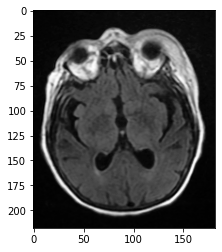

In [56]:
plt.imshow(x[:, :, 80].T, cmap='Greys_r')

(array([3177584.,  936435., 1188434.,  292404.,  207292.,  197960.,
         171262.,  141541.,   74387.,   18043.]),
 array([  1. ,  26.4,  51.8,  77.2, 102.6, 128. , 153.4, 178.8, 204.2,
        229.6, 255. ]),
 <a list of 10 Patch objects>)

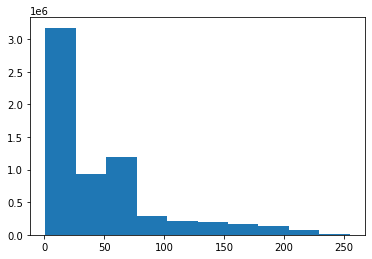

In [7]:
plt.hist(x[np.nonzero(x)])

In [9]:
q

14.0

In [22]:
mask = x > q

In [46]:
def denoise(img, mask, q):
    mask = img > q
    return ~morphology.binary_fill_holes(~mask)

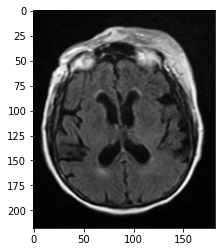

In [25]:
plt.imshow(x[:, :, 90].T, cmap='Greys_r')

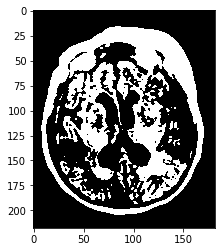

In [38]:
denoised_mask = mask.copy()
q = np.percentile(x[np.nonzero(x)], 40)
scalar = 1.4

for i in range(4):
    denoised_mask = denoise(x, denoised_mask, q)
    q = scalar * q
    

plt.imshow(denoise(x, mask, q)[:, :, 90].T, cmap='Greys_r')

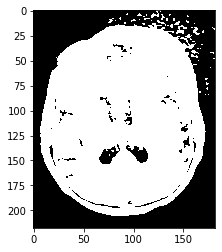

In [39]:
plt.imshow(mask[:, :, 90].T, cmap='Greys_r')

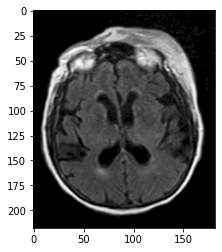

In [43]:
plt.imshow((x * mask)[:, :, 89].T, cmap='Greys_r')

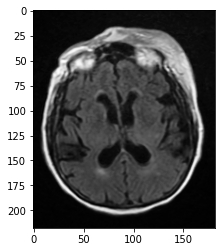

In [44]:
plt.imshow(x[:, :, 89].T, cmap='Greys_r')

In [52]:
morphology.generate_binary_structure(2, 3) 

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

# Roy Method

In [ ]:
quant = 40
scale = 1.4
n_repetitions = 4

In [213]:
def FillHoles2D(vol):
    seg = vol.copy()
    se = morphology.generate_binary_structure(2, 1)
    dim = vol.shape
    for j in range(0, dim[2]):
        test = vol[:, :, j]
        x = np.sum(test.flat)
        if x > 0:
            test = morphology.binary_fill_holes(test, structure=se)
            test = morphology.binary_fill_holes(test, structure=se)
            test = morphology.binary_fill_holes(test, structure=se)
            test = morphology.binary_closing(test, structure=se, iterations=4)
            seg[:, :, j] = test
    return seg

def apply_denoise(invol, quant, scale, n_repetitions):
    q = np.percentile(invol[invol>0], quant)
    start = invol

    for _ in range(n_repetitions):

        initmask = np.zeros_like(start,dtype=np.uint8)
        initmask[start>=q] = 1
        
        mask = initmask
        
        # apply in 2D over each axis
        for _ in range(3):
            mask = FillHoles2D(mask)
            mask = np.transpose(mask, axes=(1,2,0))

        start = np.multiply(invol,mask)
        q = q*scale 


    invol = np.multiply(invol, mask)
    
    return invol

st = time.time()
for _ in range(10):
    roy_x = apply_denoise(invol=x.get_fdata(), quant=40, scale=1.4, n_repetitions=4)
print("elapsed time: {:.2f}s".format(time.time() - st))
#roy_obj = nib.Nifti1Image(roy_x, affine=x.affine)
#nib.save(roy_obj, "test_roy.nii.gz")

elapsed time: 89.70s


# Sam Method

In [215]:
def iterative_fill_and_close(img, structure):
    for _ in range(3):
        img = morphology.binary_fill_holes(img, structure=structure)
    return morphology.binary_closing(img, structure=structure, iterations=4)

def FillHoles2D_new(vol, structure):
    tmp = np.moveaxis(vol, 2, 0)
    tmp = np.array(list(map(lambda cur_slice: iterative_fill_and_close(cur_slice, structure), tmp)))

    return np.moveaxis(tmp, 0, 2)

def apply_denoise(invol, quant, scale, n_repetitions):
    q = np.percentile(invol[invol>0], quant)
    se = morphology.generate_binary_structure(2, 1)

    for _ in range(n_repetitions):
        mask = invol >= q

        # apply in 2D over each axis
        for _ in range(3):
            mask = FillHoles2D_new(mask, structure=se)
            mask = np.transpose(mask, axes=(1,2,0))
        
        # apply mask
        invol = invol * mask
        # increase q for next iteration
        q = q * scale 
        
    return invol

st = time.time()
for _ in range(10):
    sam_x = apply_denoise(invol=x.get_fdata(), quant=40, scale=1.4, n_repetitions=4)
print("elapsed time: {:.2f}s".format(time.time() - st))

# sam_obj = nib.Nifti1Image(sam_x, affine=x.affine)
# nib.save(sam_obj, "test_sam.nii.gz")

elapsed time: 86.35s


In [217]:
np.all(roy_x == sam_x)

True